In [ ]:
!pip install -q tensorflow keras tensorflow-datasets matplotlib

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Download from Kaggle if you have a key (optional)
# Otherwise, upload manually through the left "Files" panel
!wget -q https://storage.googleapis.com/download.tensorflow.org/example_images/animals10.zip
!unzip -q animals10.zip -d /content/animals10


unzip:  cannot find or open animals10.zip, animals10.zip.zip or animals10.zip.ZIP.


In [ ]:
import pathlib
data_dir = pathlib.Path("/content/animals10/raw-img")

# Confirm dataset classes
classes = sorted([item.name for item in data_dir.glob('*') if item.is_dir()])
print("Classes:", classes)


Classes: []


In [ ]:
!pip -q install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()  # choose kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!pip -q install kaggle
import os, shutil

# Move the key to the correct location and fix permissions
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json','/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

print("✅ Kaggle API setup complete!")

✅ Kaggle API setup complete!


In [ ]:
# Step 2: Download the Animals10 dataset from Kaggle
!kaggle datasets download -d alessiocorrado99/animals10 -p /content/data

# Step 3: Unzip it
!unzip -q -o /content/data/animals10.zip -d /content/data

# Step 4: Check the folder structure
!ls /content/data/raw-img | head


Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 586M/586M [00:03<00:00, 136MB/s]
100% 586M/586M [00:03<00:00, 157MB/s]
cane
cavallo
elefante
farfalla
gallina
gatto
mucca
pecora
ragno
scoiattolo


In [ ]:
# Step 3: Load and prepare dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Folder path
DATA_DIR = "/content/data/raw-img"

# Smaller size for faster training
IMG_SIZE = (128, 128)
BATCH = 16

train_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,        # 80% training, 20% validation
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH)

val_ds = keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH)

# Show classes
class_names = train_ds.class_names
print("✅ Classes:", class_names)

# Optimize pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(500).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.
✅ Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10 -p /content/animals10


Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 96% 560M/586M [00:01<00:00, 306MB/s]
100% 586M/586M [00:01<00:00, 399MB/s]


In [ ]:
!unzip -q /content/animals10/animals10.zip -d /content/animals10


In [ ]:
import pathlib
data_dir = pathlib.Path("/content/animals10/raw-img")
print("Exists:", data_dir.exists())
print("Classes:", [p.name for p in data_dir.iterdir() if p.is_dir()])


Exists: True
Classes: ['elefante', 'cane', 'ragno', 'farfalla', 'pecora', 'scoiattolo', 'gatto', 'cavallo', 'gallina', 'mucca']


In [ ]:
from tensorflow import keras
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


In [ ]:
base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

# ISSUE 1 - MULTIPLE FINETUNING ISSUES

#base_model.trainable = False
# FREEZED LAYERS - ONLY TOP LAYERS CAN LEARN -> LOW ACCURACY
# SO WE FREEZE ONLY FRST 100 LAYERS

base_model.trainable = True

# LOW LAYERS FREEZING
for layer in base_model.layers[:100]:
    layer.trainable = False

model = keras.Sequential([
    keras.layers.Rescaling(1./255),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.1),
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(train_ds.class_names), activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
# 4 EPOCHS ISN'T ENOUGH -> INCREASE UP TO 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
    ]
)


Epoch 1/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 67s 83ms/step - accuracy: 0.6679 - loss: 1.0288 - val_accuracy: 0.9278 - val_loss: 0.2302
Epoch 2/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 74ms/step - accuracy: 0.8703 - loss: 0.4009 - val_accuracy: 0.9247 - val_loss: 0.2492
Epoch 3/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 82s 74ms/step - accuracy: 0.8945 - loss: 0.3235 - val_accuracy: 0.9150 - val_loss: 0.2771
Epoch 4/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 47s 72ms/step - accuracy: 0.9088 - loss: 0.2783 - val_accuracy: 0.9421 - val_loss: 0.2035
Epoch 5/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 83s 74ms/step - accuracy: 0.9220 - loss: 0.2373 - val_accuracy: 0.9198 - val_loss: 0.2788
Epoch 6/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.9320 - loss: 0.2116 - val_accuracy: 0.9282 - val_loss: 0.2479
Epoch 7/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.9366 - loss: 0.1933 - val_accuracy: 0.9165 - val_loss: 0.2783


In [ ]:
model.save("/content/animals10_mobilenetv2.keras", include_optimizer=False)
# (optional) also save to Drive
# model.save("/content/drive/MyDrive/animals10_mobilenetv2.keras", include_optimizer=False)


In [31]:
# class translation
class_names_it = list(train_ds.class_names)

it2en = {
    "cane":"dog", "cavallo":"horse", "elefante":"elephant", "farfalla":"butterfly",
    "gallina":"chicken", "gatto":"cat", "mucca":"cow", "pecora":"sheep",
    "ragno":"spider", "scoiattolo":"squirrel"
}

class_names_en = [it2en[c] for c in class_names_it]
print("Order check:", list(zip(class_names_it, class_names_en)))


Order check: [('cane', 'dog'), ('cavallo', 'horse'), ('elefante', 'elephant'), ('farfalla', 'butterfly'), ('gallina', 'chicken'), ('gatto', 'cat'), ('mucca', 'cow'), ('pecora', 'sheep'), ('ragno', 'spider'), ('scoiattolo', 'squirrel')]


In [ ]:
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Validation accuracy: {val_acc:.3%} | loss: {val_loss:.4f}")
class_names = train_ds.class_names


Validation accuracy: 93.945% | loss: 0.1976


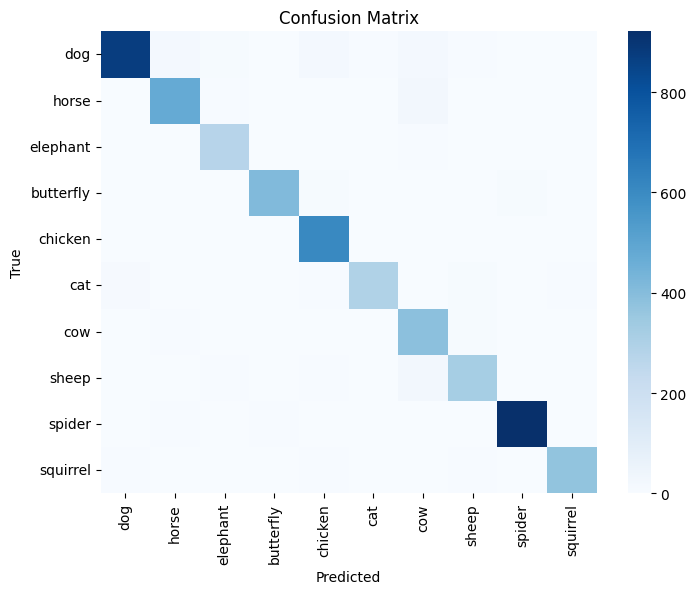

              precision    recall  f1-score   support

         dog       0.97      0.91      0.94       957
       horse       0.93      0.92      0.93       516
    elephant       0.90      0.97      0.94       283
   butterfly       0.98      0.95      0.96       432
     chicken       0.92      0.99      0.95       612
         cat       0.98      0.89      0.93       330
         cow       0.82      0.95      0.88       406
       sheep       0.91      0.88      0.89       365
      spider       0.99      0.98      0.98       939
    squirrel       0.97      0.94      0.96       395

    accuracy                           0.94      5235
   macro avg       0.94      0.94      0.94      5235
weighted avg       0.94      0.94      0.94      5235

Saved: /content/confusion_matrix.csv


In [34]:
!pip -q install scikit-learn seaborn
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

y_true, y_pred = [], []
for x, y in val_ds:
    p = model.predict(x, verbose=0)
    y_pred.extend(np.argmax(p, axis=1))
    # y may be sparse or one-hot; handle both:
    y_true.extend(y.numpy().argmax(axis=1) if len(y.shape) > 1 else y.numpy())

cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
df_cm = pd.DataFrame(cm, index=class_names_en, columns=class_names_en)

plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=False, cmap="Blues", fmt="d")
plt.ylabel("True"); plt.xlabel("Predicted"); plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names_en, digits=2))
df_cm.to_csv("/content/confusion_matrix.csv")
print("Saved: /content/confusion_matrix.csv")


Saving Elefant.avif to Elefant (4).avif


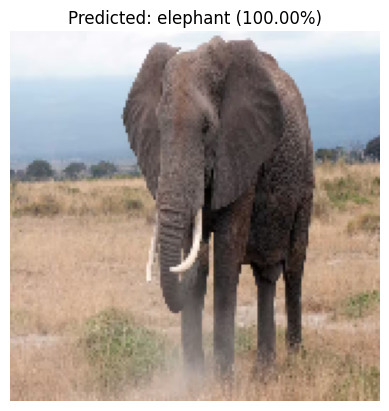

In [35]:
from google.colab import files
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (160, 160)  # same as training

uploaded = files.upload()  # choose a JPG/PNG

for fn in uploaded.keys():
    img = keras.utils.load_img(fn, target_size=IMG_SIZE)
    #x = keras.applications.mobilenet_v2.preprocess_input(x)
    # ISSUE 2 - ANOTHER IMAGE PROCESSING METHOD, THEN DURING THE MODEL TRAINING
    x = keras.utils.img_to_array(img)[None, ...]   # 0..255
    p = model.predict(x, verbose=0)[0]
    i = int(np.argmax(p))
    conf = float(np.max(p))
    pred_label_en = class_names_en[i]

    plt.imshow(img); plt.axis("off")
    plt.title(f"Predicted: {pred_label_en} ({conf:.2%})")
    plt.show()



Now the results are good, but there are still a gap to improve(better finetuning, unbalanced dataset issue fix)
